In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

pd.set_option('display.max_columns', None)

import time

# 0 CLEANING

In [2]:
data =pd.read_csv("we_fn_use_c_marketing_customer_value_analysis.csv")

In [3]:
def little_clean(x):
    #lower columns
    x.columns=[e.lower().replace(' ', '_') for e in x.columns]  
    #date type
    x['effective_to_date'] = pd.to_datetime(x.effective_to_date)
    
    #HERE IS THE FIFHT PART OF THE EXCERCISE
    x['effective_to_date'] = x["effective_to_date"].apply(pd.Timestamp)
    x['effective_to_date'] = x['effective_to_date'].apply(lambda x: round((int(time.mktime(time.strptime(str(x), '%Y-%m-%d %H:%M:%S')))/86400)))
    #x.drop(['effective_to_date'], axis = 1, inplace = True)
    
    x.drop(['policy_type'], axis = 1, inplace = True)
    #lower values
    for catname in x.select_dtypes('object').columns:
        x[catname]= [e.lower().replace(' ', '_') for e in x[catname]]
    
    x = x.set_index('customer')
    
    return x

data = little_clean(data)

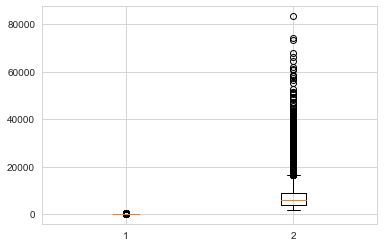

In [4]:
list_to_outlier = ['monthly_premium_auto', 'customer_lifetime_value']

plt.boxplot(data[list_to_outlier])
plt.show()

In [5]:

def log_transform_clean(x):
    if np.isfinite(x) and x!=0:
        return np.log(x)
    else:
        return np.NAN

for i in list_to_outlier:
    data[i] = data[i].apply(log_transform_clean)


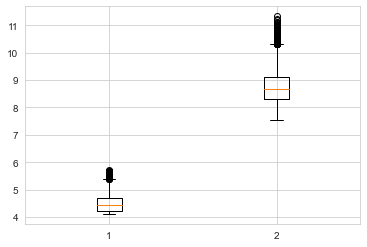

In [6]:
plt.boxplot(data[list_to_outlier])
plt.show()

In [7]:
data_copy = data

In [8]:
#data_copy.info()

In [9]:
def con_dis_classifier (df):
    continuous  = []
    discrete    = []
    categorical = []
    for col in df.columns:
        if(df[col].dtypes == object): #OBJECTS
            categorical.append(col)
        else:
            if(df[col].dtypes in ['float', 'int', 'int64', 'float64']): #NUMBERS         
                if (len(data[col].unique())) > 1000: #HIGH VALUES means KIND of continuous regression
                    continuous.append(col)
                else:
                    discrete.append(col) 
            else:
                discrete.append(col) #data
            
    return continuous,discrete, categorical

continuous_ ,discrete_ , categorical_ = con_dis_classifier(data_copy)

continuous_data  = data_copy[continuous_]
discrete_data    = data_copy[discrete_]
categorical_data = data_copy[categorical_]

In [10]:
#continuous_data.head()

In [11]:
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler

def scaling_data (data, scaler = MinMaxScaler()):
    transformer = scaler.fit(data)
    optimusprime = transformer.transform(data)
    data = pd.DataFrame(optimusprime, columns = data.columns)
    return data

continuous_scaled = scaling_data(continuous_data, StandardScaler())

In [12]:
#ENCODE ORDINAL DATA
categorical_data["coverage"] = categorical_data["coverage"].map({"basic" : 0, "extended" : 1, "premium" : 2})
categorical_data["employmentstatus"] = categorical_data["employmentstatus"].map({"employed" : 1, "unemployed" : 0, "medical_leave" : 0, "disabled" : 0,  "retired" : 0})
categorical_data["location_code"] = categorical_data["location_code"].map({"urban" : 0, "suburban" : 1, "rural" : 2})
categorical_data["vehicle_size"] = categorical_data["vehicle_size"].map({"small" : 0, "medsize" : 1, "large" : 2})


In [13]:
toencode=["state","marital_status","gender","response","education","policy","renew_offer_type","sales_channel","vehicle_class"]


In [14]:
def dummies(x, column):
    bp_dummies = pd.get_dummies(x[column])
    x = pd.concat([x, bp_dummies], axis = 1)
    x.drop([column], axis = 1, inplace = True)
    return x

for dummy in toencode:
       categorical_data = dummies(categorical_data,dummy)


In [15]:
#semi_full_data = continuous_data.append(categorical_data)
#categorical_data
full_data = pd.concat([continuous_data,categorical_data,discrete_data], axis = 1)

In [16]:
#full_data.shape

In [17]:
#full_data.head(10)

# 1

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
#y = full_data['total_claim_amount']
#X = full_data.drop('total_claim_amount', axis = 1)

In [20]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# 2

Try a simple linear regression with all the data to see whether we are getting good results.

In [21]:
#from sklearn.linear_model import LinearRegression

In [22]:
#reg_model = LinearRegression().fit(X_train, y_train)

In [23]:
#lm_predictions = reg_model.predict(X_test)

In [24]:
#from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#MAE = mean_absolute_error(y_test,lm_predictions)
#MSE = mean_squared_error(y_test,lm_predictions)
#RMSE = np.sqrt(MSE)
#R2 = r2_score(y_test,lm_predictions)

#print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
#print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
#print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
#print("The R2 of the model in the test set is: %4.2f" % (R2))

# 3

Great! Now define a function that takes a list of models and train (and tests) them so we can try a lot of them without repeating code.

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [27]:
def train_test_model(model, y_target, x_data, random_seed):
    #traintest split
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.3, random_state=random_seed)
    #fitmodel
    fitt_model = model.fit(X_train, y_train)
    my_predictions = fitt_model.predict(X_test)
    #results
    MAE = mean_absolute_error(y_test,my_predictions)
    MSE = mean_squared_error(y_test,my_predictions)
    RMSE = np.sqrt(MSE)
    R2 = r2_score(y_test,my_predictions)

    print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
    print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
    print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
    print("The R2 of the model in the test set is: %4.2f" % (R2))

    sns.scatterplot(y = my_predictions, x = y_test)
    return


In [28]:
#def tran_test_dif_models()

# 4

In [29]:
y = full_data['total_claim_amount']
X = full_data.drop('total_claim_amount', axis = 1)

The mean absolute error of the model in the test set is: 129.85
The mean squared error of the model in the test set is: 30796.95
The root mean squared error of the model in the test set is: 175.49
The R2 of the model in the test set is: 0.61


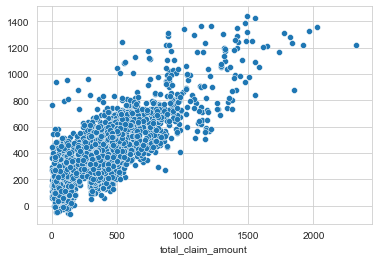

In [30]:
train_test_model(LinearRegression(),y,X,100)

The mean absolute error of the model in the test set is: 198.07
The mean squared error of the model in the test set is: 74097.73
The root mean squared error of the model in the test set is: 272.21
The R2 of the model in the test set is: 0.07


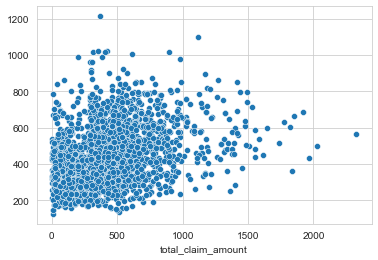

In [31]:
train_test_model(KNeighborsRegressor(n_neighbors=10),y,X,100)

The mean absolute error of the model in the test set is: 185.44
The mean squared error of the model in the test set is: 60898.10
The root mean squared error of the model in the test set is: 246.78
The R2 of the model in the test set is: 0.24


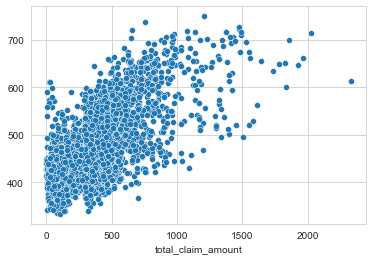

In [32]:
train_test_model(MLPRegressor(),y,X,100)

The mean absolute error of the model in the test set is:  90.87
The mean squared error of the model in the test set is: 17256.47
The root mean squared error of the model in the test set is: 131.36
The R2 of the model in the test set is: 0.78


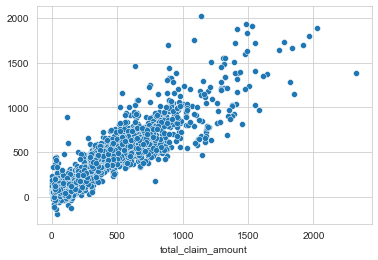

In [36]:
train_test_model(make_pipeline(PolynomialFeatures(2), Ridge()),y,X,100)